In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
fmri = sns.load_dataset("fmri")

In [3]:
fmri

,subject,timepoint,event,region,signal
0,s13,18,stim,parietal,-0.017552
1,s5,14,stim,parietal,-0.080883
2,s12,18,stim,parietal,-0.081033
3,s11,18,stim,parietal,-0.046134
4,s10,18,stim,parietal,-0.037970
5,s9,18,stim,parietal,-0.103513
6,s8,18,stim,parietal,-0.064408
7,s7,18,stim,parietal,-0.060526
8,s6,18,stim,parietal,-0.007029
9,s5,18,stim,parietal,-0.040557


/Users/tianxie/anaconda/envs/mlearn/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


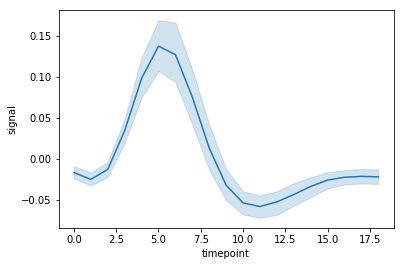

In [5]:
ax = sns.lineplot(x="timepoint", y="signal", data=fmri)

In [22]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import initiate.config as config
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from subprocess import call
from collections import Counter
from visualization.plot_heatmap import plot_correction_heatmap

'''
:1 Create correction heatmap function v

:2 Create graph function for case study: 
    x: change number of driver
    y: average accuracy 
'''


def load_json_file(folder, file_name):
    file_name = os.path.join(folder, file_name)

    with open(file_name, "r") as json_file:
        travel_distance_frequency_dict = json.load(json_file)
    return travel_distance_frequency_dict


def driving_date_figure(driving_time_dict):
    """
    Show How many days each driver drives their vehicle. Used to
    determine train/test data ratio
    :return:
    """
    driver_num = len(driving_time_dict.keys())
    driver_idx = 0
    driving_date_matrix = None
    for driver_id in driving_time_dict.keys():
        local_driving_dict = driving_time_dict[driver_id]
        for time_string in local_driving_dict.keys():

            if driving_date_matrix is None:
                driving_date_matrix = np.zeros((driver_num, 30))

            date_idx = int(time_string.split("-")[-1]) - 1
            driving_date_matrix[driver_idx, date_idx] = 1
        driver_idx += 1

    # plt.figure(figsize=[6, 7])
    plt.imshow(driving_date_matrix, cmap="gray_r")
    plt.colorbar()
    plt.title("Driving date display")
    plt.xlabel("Day in a month")
    plt.ylabel("Driver sequence")
    save_figure_path = os.path.join(
        config.figures_folder, config.Learn2classify_test_folder)
    if not os.path.exists(save_figure_path):
        os.mkdir(save_figure_path)
    plt.savefig(os.path.join(save_figure_path, "driving date test" + ".png"))
    plt.close()


def data_process_for_classify(link_level_dict, driving_time_dict):
    """
    Construct each driver's daily driving data as a vector for SVD classify
    :param link_level_dict:
    :return:
    """
    # construct total_link_set
    total_link_set = []
    for driver_id in link_level_dict.keys():
        local_driving_dict = link_level_dict[driver_id]
        for time_string in local_driving_dict.keys():
            local_driver_link_dict = local_driving_dict[time_string]
            for link_string in local_driver_link_dict.keys():
                local_link = link_string
                if local_link not in total_link_set:
                    total_link_set.append(link_string)

    # construct rd_dict
    RD_dict = {}
    for driver_id in link_level_dict.keys():
        local_driving_dict = link_level_dict[driver_id]
        if driver_id not in RD_dict.keys():
            RD_dict[driver_id] = {}
        for date in local_driving_dict.keys():
            local_driver_link_dict = local_driving_dict[date]
            if date not in RD_dict[driver_id].keys():
                RD_dict[driver_id][date] = []
            for link_set_string in total_link_set:
                if link_set_string in local_driver_link_dict.keys():
                    distance = local_driver_link_dict[link_set_string]['distance']
                    RD_dict[driver_id][date].append(distance)
                else:
                    RD_dict[driver_id][date].append(0.0)
    for driver_id in driving_time_dict.keys():
        if driver_id not in RD_dict.keys():
            print(
                "Error! driver id not in RD_dict. driving_time_dict not match with link_level_dict!")
            exit()
        local_driving_dict = driving_time_dict[driver_id]
        svd_driver_dict = RD_dict[driver_id]
        for date in local_driving_dict.keys():
            local_driving_time_list = local_driving_dict[date]
            # some driver may have driving time but don't have link info
            # *************  this problem needs further discuss *******************
            if date not in svd_driver_dict.keys():
                # print(date)
                # print(driver_id)
                # print("Error! driver date not in RD_dict. driving_time_dict not match with link_level_dict!")
                # exit()
                zero_distance_in_all_link_set = [0.0] * len(total_link_set)
                RD_dict[driver_id][date] = zero_distance_in_all_link_set
            for travel_time in local_driving_time_list:
                RD_dict[driver_id][date].append(travel_time)
    return RD_dict


def RandomForest(RD_dict_org, experiment_num=100, plot_correction_flag=True, random_select_driver=False, driver_num=None):
    """

    :param RD_dict:
    :param experiment_num:
    :param plot_correction_flag:
    :return:
    """
    
    '''
    PCA: reduce dimension 
    Sigma = V D V^t
    D: (…, M) array, The eigenvalues, each repeated according to its multiplicity
    V: (…, M, M) array, The normalized (unit “length”) eigenvectors
    '''
    #Sigma = np.cov(svd_matrix.T, rowvar=False)
    #D, V = np.linalg.eig(Sigma)
    #print('D:', D.shape)
    #print('V:', V.shape)
    #sorted_D = np.sort(D)
    #plot_list = sorted_D[::-1][100:200]
    #print('Non zero Eigen value:', sum([1 for v in sorted_D if v > 0.1]))
    #x = [i for i in range(0, len(plot_list))]
    #plt.scatter(x, plot_list, color='k', s=10)
    #plt.ylabel('Eig Value')
    # plt.xlabel('k')
    # save_figure_path = os.path.join(
    #    config.figures_folder, config.Learn2classify_test_folder)
    # if not os.path.exists(save_figure_path):
    #    os.mkdir(save_figure_path)
    # plt.savefig(os.path.join(save_figure_path,
    #                         "Random Forest PCA" + ".png"))
    # plt.close()
    ################################################
    # Transforming to PCA space
    ################################################
    #k = 200
    #projecting_v = V[:, np.argsort(D)[::-1][:k]]
    #print('projecting_v.shape:', projecting_v.shape)
    #svd_matrix = svd_matrix.T.dot(projecting_v).T
    ################################################

    # Random Forest
    pcorr_list = []
    correction_table = np.zeros((driver_num, experiment_num))
    correction = np.zeros((driver_num, experiment_num))
    for iteration in range(experiment_num):
        if random_select_driver==False:
            RD_dict = RD_dict_org
        else:
            selected_driver_list = random.sample(RD_dict_org.keys(), driver_num)
            RD_dict = {}
            for s in selected_driver_list:
                RD_dict[s] = RD_dict_org[s]
                
        # Construct driver_id--label dict and driver_num
        driver_num = len(RD_dict.keys())
        driver_id2label_dict = {}
        count = 0
        for driver_id in RD_dict.keys():
            driver_id2label_dict[driver_id] = count
            count += 1

        # Construct SVD matrix
        data_list = []
        label_list = []
        for driver_id in RD_dict.keys():
            local_driving_dict = RD_dict[driver_id]
            for date in local_driving_dict.keys():
                sample_driving_data = local_driving_dict[date]
                data_list.append(sample_driving_data)
                label_list.append(driver_id2label_dict[driver_id])
        # keep this name same as the SVD classifier
        svd_matrix = (np.array(data_list)).transpose()
        # Count how many data each driver has
        #print('Driver data dict: ', Counter(label_list))
        
        # do lexperiment_num times
        # divid svd_matrix into train matrix and test matrix
        svd_matrix_train, svd_matrix_test, label_train, label_test = \
            divide_data_2_train_test(RD_dict, svd_matrix, label_list)

        # Learn Random Forest
        classifier = learn_RandomForest(
            RD_dict, svd_matrix_train.transpose(), label_train)
        # Classify test set
        predicted_label = predict_RandomForest(
            classifier, svd_matrix_test.transpose())
        # Calculate correct percentage
        pcorr = pcorrect(predicted_label, label_test)
        pcorr_list.append(pcorr)
        # construct correction table
        tmp = []
        correction_tmp = []
        for i in range(len(predicted_label)):
            if predicted_label[i] == label_test[i]:
                tmp.append(1)
                correction_tmp.append(predicted_label[i])
            else:
                tmp.append(0)
                correction_tmp.append(predicted_label[i])
        correction_table[:, iteration] = tmp
        correction[:, iteration] = correction_tmp
    local_mean_acc = sum(pcorr_list) / len(pcorr_list)
    # export tree image for (each) of the tree in Random Forest
    #for tree_id in range(10):
    #    estimator = classifier.estimators_[tree_id]
        # Export the last classifier as dot file
        #export_graphviz(estimator, out_file='tree/tree'+str(tree_id)+'.dot',
        #                rounded=True, proportion=False,
        #                precision=3, filled=True)
        #'''Exporting .png process may take long time'''
        # Convert to png using system command (requires Graphviz)
        # call(['dot', '-Tpng', 'tree/tree'+str(tree_id)+'.dot', '-o',
        #      'tree/tree'+str(tree_id)+'.png', '-Gdpi=300'])
    # plot correction table .csv
    #test(correction)
    # plot correction table
    if plot_correction_flag is True:
        plot_correction_table(correction_table)
    #plot_each_driver_accuracy(RD_dict, correction_table)
    # plot accuracy figure
    #mean_accuracy = plot_accuracy_figure(pcorr_list, experiment_num)

    # plot heatmap
    #plot_correction_heatmap(RD_dict, correction, mean_accuracy)

    return pcorr_list


def plot_each_driver_accuracy(RD_dict, correction_table):
    plt.figure(figsize=[14, 4])
    X = range(len(RD_dict.keys()))
    Xticks = RD_dict.keys()
    y = np.mean(correction_table, axis=1)
    plt.plot(X, y, 'k-')
    plt.xticks(ticks=X, labels=Xticks)
    plt.title("Driver with accuracy")
    plt.xlabel("Driver ID")
    plt.ylabel("mean accuracy")
    for i, n in enumerate([len(RD_dict[k].keys()) for k in RD_dict.keys()]):
        plt.annotate(n, (X[i], y[i]))
    save_figure_path = os.path.join(
        config.figures_folder, config.Learn2classify_test_folder)
    if not os.path.exists(save_figure_path):
        os.mkdir(save_figure_path)
    plt.savefig(os.path.join(save_figure_path,
                             "Random Forest Driver Accuracy" + ".png"))
    plt.close()


def test(correction):
    np.savetxt("correction tabel RD.csv", correction, delimiter=",",
               fmt='%10.5f')


def plot_accuracy_figure(pcorr_list, experiment_num):
    mean_accuracy = [sum(pcorr_list) / len(pcorr_list)] * \
        (len(pcorr_list) + 10)
    print("mean accuracy", mean_accuracy[0])
    x = [i for i in np.arange(0, experiment_num, 1)]
    x1 = [i for i in np.arange(-5, experiment_num+5, 1)]
    f1 = plt.plot(x, pcorr_list, color='k')
    f2 = plt.plot(x1, mean_accuracy, 'b--')
    plt.legend(f2, "mean accuracy")
    plt.title("Accuracy in {} times experiment, # of test data: {}".format(
        experiment_num, len(pcorr_list)))
    # plt.grid(linewidth=0.3)
    plt.xlabel("experiment idx")
    plt.ylabel("accuracy")
    # plt.show()
    save_figure_path = os.path.join(
        config.figures_folder, config.Learn2classify_test_folder)
    if not os.path.exists(save_figure_path):
        os.mkdir(save_figure_path)
    plt.savefig(os.path.join(save_figure_path,
                             "Random Forest 11 test data" + ".png"))
    plt.close()
    return np.mean(mean_accuracy)


def plot_correction_table(correction_table):
    plt.figure(figsize=[14, 4])
    plt.imshow(correction_table, cmap='gray', aspect='auto')
    plt.colorbar(ticks=range(2), label="classify correct or not")
    plt.title("1:correct 0:incorrect")
    plt.xlabel("Experiment idx")
    plt.ylabel("Driver idx")
    save_figure_path = os.path.join(
        config.figures_folder, config.Learn2classify_test_folder)
    if not os.path.exists(save_figure_path):
        os.mkdir(save_figure_path)
    plt.savefig(os.path.join(save_figure_path,
                             "Random Forest correction table" + ".png"))
    plt.close()


def divide_data_2_train_test(RD_dict, svd_matrix, label_list):
    '''
    Pick one data randomly from each driver's data as test data 
    '''
    # divid svd_matrix into train matrix and test matrix
    driver_num = len(RD_dict.keys())
    test_idx = []  # store the index of test data
    svd_matrix_test = None
    for i in range(driver_num):
        data_idx = [j for j, x in enumerate(label_list) if x == i]
        start_idx = data_idx[0]
        end_idx = data_idx[-1]
        idx_list = np.arange(start_idx, end_idx + 1, 1)
        # randomly choose one data as test sample
        chosen_test_idx = random.choice(idx_list)
        test_idx.append(chosen_test_idx)
        dim = svd_matrix[:, 0].shape[0]
        local_data = np.reshape(svd_matrix[:, chosen_test_idx], (dim, 1))
        if svd_matrix_test is None:
            svd_matrix_test = local_data
        else:
            svd_matrix_test = np.hstack((svd_matrix_test, local_data))
    svd_matrix_train = np.delete(svd_matrix, test_idx, 1)
    label_train = label_list[:]
    label_test = []
    for x in test_idx[::-1]:
        label_test.append(label_list[x])
        label_train = label_train[:x] + label_train[x + 1:]
    label_test = label_test[::-1]
    return svd_matrix_train, svd_matrix_test, label_train, label_test


def learn_RandomForest(RD_dict, svd_matrix, label_list):
    classifier = RandomForestClassifier(n_estimators=40,
                                        criterion='gini',
                                        max_depth=21,
                                        min_samples_split=2,
                                        random_state=0)
    classifier.fit(svd_matrix, label_list)
    return classifier


def predict_RandomForest(classifier, test_matrix):
    predicted_label = classifier.predict(test_matrix)
    return predicted_label


def pcorrect(predicted_label, test_label):
    count = 0
    for i in range(len(predicted_label)):
        predict = predicted_label[i]
        real = test_label[i]
        if predict == real:
            count += 1
        else:
            continue
    percent = count / len(predicted_label)
    return percent


def RDclassify(folder):
    # load the travel distance and frequency data
    # travel_distance_frequency_dict = load_json_file(folder, config.grid_travel_info)
    # print("Now plot the travel distance and frequency figures...")
    # # generate_grid_travel_figures(travel_distance_frequency_dict)
    #
    # # load the driving time data
    all_driving_time_dict = load_json_file(folder, config.driving_time_info)
    # print(driving_time_dict['10125'].keys())

    # load the link-level data
    all_link_level_dict = load_json_file(folder, config.link_level)

    RD_dict_org = data_process_for_classify(
        all_link_level_dict, all_driving_time_dict)
    num_of_exp_per_driverNum = 100
    drive_acc_mat = np.array([])
    for i in range(2, 12):
        pcorr_list = RandomForest(RD_dict_org,  experiment_num=num_of_exp_per_driverNum, random_select_driver=True, driver_num=i)
        local_drive_acc_mat = np.hstack((np.ones((num_of_exp_per_driverNum,1))*i, np.array(pcorr_list).reshape(-1,1)))
        print('local_drive_acc_mat.shape', local_drive_acc_mat.shape)
        if drive_acc_mat.shape[0] ==0:
            drive_acc_mat = np.array(local_drive_acc_mat)
        else:
            drive_acc_mat = np.vstack((drive_acc_mat, local_drive_acc_mat))
    return drive_acc_mat

r_m = RDclassify("ann_arbor")


RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2
RD_dict 2


RD_dict 9
RD_dict 9
RD_dict 9
RD_dict 9
RD_dict 9
local_drive_acc_mat.shape (100, 2)
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD_dict 10
RD

In [10]:
np.array([]).shape[0]

0

In [13]:
r_m

(1100, 2)

In [16]:
list(range(1,12))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [23]:
r_m

array([[ 2.        ,  1.        ],
       [ 2.        ,  1.        ],
       [ 2.        ,  1.        ],
       ...,
       [11.        ,  0.72727273],
       [11.        ,  0.72727273],
       [11.        ,  0.72727273]])

/Users/tianxie/anaconda/envs/mlearn/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'Accuracy')

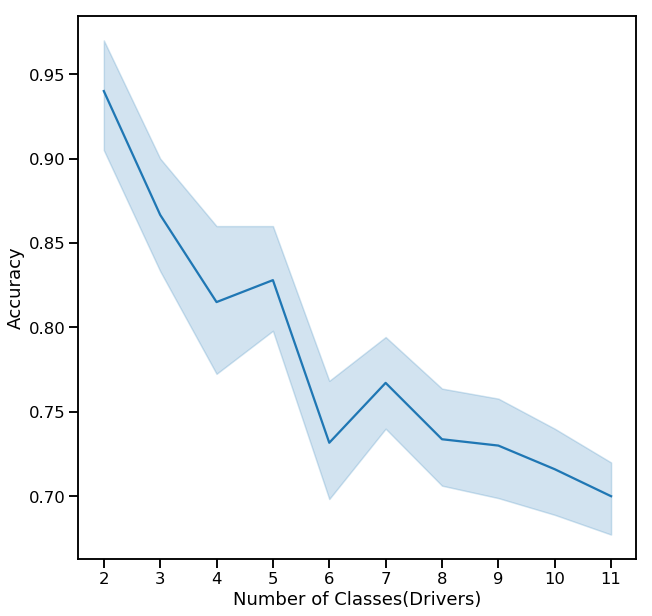

In [26]:
sns.set_context('talk')
plt.figure(figsize=(10,10))
ax = sns.lineplot(x=r_m[:,0], y=r_m[:,1])

plt.xticks(range(2,12))

plt.xlabel('Number of Classes(Drivers)')
plt.ylabel('Accuracy')